In [2]:
import os
os.chdir(r"D:\PhD Classes (Big_files)\Neural Networks\Neural Networks\Project\ResNet50\Validation")

In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import rasterio
import sys
import PIL # pillow - image processing

In [4]:
img_dir = r"image_2nd_dataset\24813_sat.jpg"
model_dir = r"D:\PhD Classes (Big_files)\Neural Networks\Neural Networks\Project\Tutorial_1\ResNet50_eurosat.h5"

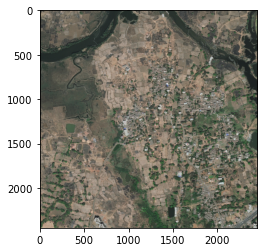

In [5]:
img = PIL.Image.open(img_dir, 'r')
img_array = np.asarray(img)/255.0
plt.imshow(img_array[:,:,:])

In [6]:
img_array.shape

(2448, 2448, 3)

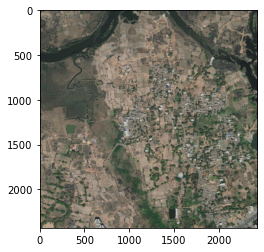

In [7]:
img_clipped = img_array[0:2432,0:2432,:]
plt.imshow(img_clipped[:,:,:])

In [8]:
start = datetime.now()
ROWS = img_clipped.shape[0]
COLS = img_clipped

In [9]:
img_clipped.shape[0]

2432

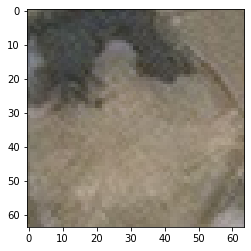

In [10]:
little_img = img_clipped[0:0+64, 0:0+64,:]
plt.imshow(little_img[:,:,:])

In [11]:
little_img[:,:,2]

array([[0.41176471, 0.42745098, 0.40784314, ..., 0.38039216, 0.38431373,
        0.41176471],
       [0.38431373, 0.34117647, 0.35294118, ..., 0.41568627, 0.39215686,
        0.37647059],
       [0.30196078, 0.29411765, 0.29803922, ..., 0.43529412, 0.41568627,
        0.39607843],
       ...,
       [0.27843137, 0.34509804, 0.32156863, ..., 0.54901961, 0.57254902,
        0.56862745],
       [0.28235294, 0.33333333, 0.34901961, ..., 0.61176471, 0.61176471,
        0.58431373],
       [0.35294118, 0.3372549 , 0.34901961, ..., 0.62745098, 0.65098039,
        0.62352941]])

In [12]:
a = little_img.reshape(1, 64, 64, 3).astype('float16')
a[0,:,:,2]

array([[0.4119, 0.4275, 0.408 , ..., 0.3804, 0.3843, 0.4119],
       [0.3843, 0.341 , 0.353 , ..., 0.4158, 0.392 , 0.3765],
       [0.302 , 0.2942, 0.298 , ..., 0.4353, 0.4158, 0.396 ],
       ...,
       [0.2783, 0.3452, 0.3215, ..., 0.549 , 0.5728, 0.569 ],
       [0.2825, 0.3333, 0.349 , ..., 0.612 , 0.612 , 0.5845],
       [0.353 , 0.3372, 0.349 , ..., 0.6274, 0.651 , 0.6235]],
      dtype=float16)

# Predicting  each 64x64 pixel

In [13]:
# Load the model one time
resnet50_model = tf.keras.models.load_model(model_dir)

In [15]:
steps = 64 # pixels
start = datetime.now()
prediction_file = open("predictions.txt", "w")
for i in range(0,img_clipped.shape[0],steps):

    predictions = []
    print("Processing Row: %s @ %s" % (i, datetime.now()))
    for j in range(0,img_clipped.shape[1],steps):
               
        # Create tile
        little_img = img_clipped[i:i+64, j:j+64,:]

        # Predict
        predicted = resnet50_model.predict(little_img.reshape(1, 64, 64, 3).astype('float16'))
        predictions.append(str(predicted.argmax()))

        # Optimization        
        del little_img, predicted
        K.clear_session()
    
    # Flush the predictions of row to file
    prediction_file.write(("%s," % i) + ",".join(predictions) + "\n")
    prediction_file.flush()
    sys.stdout.flush()

    # Optimization
    if i % 10 == 0:
        del resnet50_model
        K.clear_session()
        resnet50_model = tf.keras.models.load_model(model_dir)

end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))
prediction_file.close()

Processing Row: 0 @ 2021-04-29 11:42:10.381431
Processing Row: 64 @ 2021-04-29 11:42:22.707074
Processing Row: 128 @ 2021-04-29 11:42:24.740242
Processing Row: 192 @ 2021-04-29 11:42:26.272309
Processing Row: 256 @ 2021-04-29 11:42:27.723488
Processing Row: 320 @ 2021-04-29 11:42:29.396935
Processing Row: 384 @ 2021-04-29 11:42:39.998907
Processing Row: 448 @ 2021-04-29 11:42:42.091224
Processing Row: 512 @ 2021-04-29 11:42:43.521690
Processing Row: 576 @ 2021-04-29 11:42:44.991756
Processing Row: 640 @ 2021-04-29 11:42:46.436331
Processing Row: 704 @ 2021-04-29 11:42:56.576240
Processing Row: 768 @ 2021-04-29 11:42:58.674150
Processing Row: 832 @ 2021-04-29 11:43:00.044446
Processing Row: 896 @ 2021-04-29 11:43:01.451362
Processing Row: 960 @ 2021-04-29 11:43:03.071465
Processing Row: 1024 @ 2021-04-29 11:43:13.242178
Processing Row: 1088 @ 2021-04-29 11:43:15.281722
Processing Row: 1152 @ 2021-04-29 11:43:16.657347
Processing Row: 1216 @ 2021-04-29 11:43:18.032031
Processing Row: 128

# Plotting the predicted labels

In [16]:
prediction = "predictions.txt"
TEST_IMG = "13Bands_Cropped.tif"
classes = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 
           4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 
           7: 'Residential', 8: 'River', 9: 'SeaLake'}


# Read the Predictions file
rows = {}
with open(prediction) as data:
    for row in data:
        values = [int(i) for i in row.split(",")]
        rows[values[0]] = values[1:]
predicted_img = np.array([*rows.values()])

In [ ]:

# Write as a raster
with rasterio.open(TEST_IMG) as src_dataset:
    
    test_img = src_dataset.read((2, 3, 4))
    kwds = src_dataset.profile
    kwds['count'] = 1          # Changing the no. of bands to 1
    kwds['dtype'] = 'int32'    # Changing the datatype
   
    with rasterio.open('precitions.tif', 'w', **kwds) as dst_dataset:
        dst_dataset.write(predicted_img, 1)
# Plotting
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Test image plot
test_img = ((test_img / (2**12-1)) * 255).astype('uint8')
img1 = ax1.imshow(np.transpose(test_img, (1, 2, 0)))
plt.colorbar(img1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title("Test image (in 8-bit)")

# Predicted plot
img2 = ax2.imshow(predicted_img)
cbar = plt.colorbar(img2, fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(classes.values())
ax2.set_title("Predicted raster (ResNet50)")

# Display the plot
plt.show()

C:\Users\said_\Anaconda3\envs\Tensorflow_Deep_Learning\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


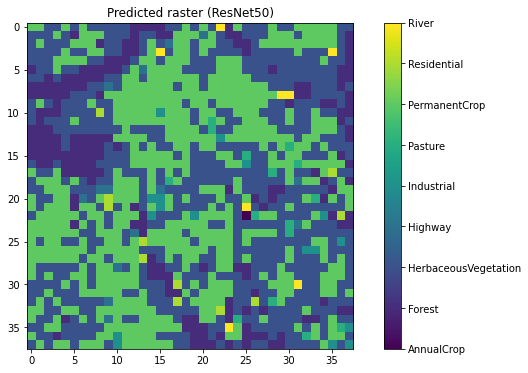

In [18]:
# Plotting
fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# Predicted plot
img2 = ax2.imshow(predicted_img)
cbar = plt.colorbar(img2, fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(classes.values())
ax2.set_title("Predicted Classes from image")

# Display the plot
plt.show()

In [ ]:
import matplotlib
from matplotlib.colors import ListedColormap

def plot_label(mask, labels, col_dict)
	# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
	# col_dict={1:"blue",
	#           2:"red",
	#           3:"orange",
	#           4:"green",
	#           5:"yellow",
	#           6:"purple",
	#           7:"grey"}
	
	# We create a colormar from our list of colors
	cm = ListedColormap([col_dict[x] for x in col_dict.keys()])
	
	# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
	# labels = np.array(['urban_land','agriculture_land','rangeland','forest_land','water','barren_land','unknown'])
	len_lab = len(labels)
	
	
	# prepare normalizer
	## Prepare bins for the normalizer
	norm_bins = np.sort([*col_dict.keys()]) + 0.5
	norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
	print(norm_bins)
	## Make normalizer and formatter
	norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
	fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
	
	# Plot our figure
	fig,ax = plt.subplots()
	im = ax.imshow(mask, cmap=cm, norm=norm)
	
	diff = norm_bins[1:] - norm_bins[:-1]
	tickz = norm_bins[:-1] + diff / 2
	cb = fig.colorbar(im, format=fmt, ticks=tickz)
	return fig